## 2) Implement a “grid search”

Investigate the follow parameters:

- activation units (sigmoid, relu, elu, etc.),

- different minimization algorithms (ADAM, RMSprop, Nesterov, etc.),

- different dropouts

- batch normalization

- different size or number of layers

In [1]:
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 1
%aimport nn_model
%aimport create_data
%aimport preprocess

### 2.1) Create dataset

In [15]:
# number of data
N = 5000
# box size
B = 100

# random seed for reproducibility
np.random.seed(20220308)

x = create_data.sample_data(N, B)
y = create_data.assign_label(x)

mean = np.mean(x, axis=0)
std = np.std(x, axis=0)

# re-scaling data 
x_scaled = preprocess.standardize(x, mean, std)

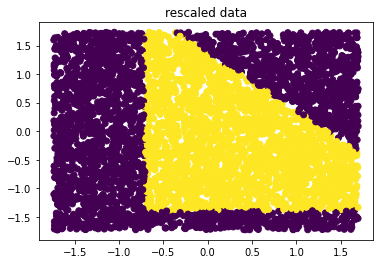

In [16]:
plt.scatter(x_scaled[:,0], x_scaled[:,1], c=y)
plt.title("rescaled data")
plt.show()

In [17]:
## SPLIT TRAIN AND VALID
train_frac = 0.7

N_train = int(N*train_frac)

training_data, training_labels = np.copy(x_scaled[0:N_train]), np.copy(y[0:N_train])
test_data,     test_labels     = np.copy(x_scaled[N_train:]),  np.copy(y[N_train:])

print(f"Traing set :\t{training_data.shape[0]}\nTest set  :\t{test_data.shape[0]}")

N_valid = 500

x_train, y_train = np.copy(training_data[N_valid:]),  np.copy(training_labels[N_valid:])
x_valid, y_valid = np.copy(training_data[0:N_valid]), np.copy(training_labels[0:N_valid])

print(f"\nN_train :\t{x_train.shape[0]} \nN_valid :\t{x_valid.shape[0]}")

Traing set :	3500
Test set  :	1500

N_train :	3000 
N_valid :	500


### 2.2) Define NN and its architecture

In [18]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(
    n_features,
    neurons           = [20, 20, 1],
    dropout_arc       = [1],
    dropout_rates     = [0.2],
    batch_norm_arc    = [2],
    hidden_activation = "relu",
    output_activation = "sigmoid",
    name              = "my lovely neural network",
    loss              = "binary_crossentropy",
    optimizer         = "adam",
    metrics           = ["accuracy"]
):
    # initialize architecture
    architecture = [n_features] + neurons
    input_dim    = n_features

    # create model
    network = nn_model.NN(
        input_dim         = input_dim,
        architecture      = architecture,
        dropout_layers    = dropout_arc,
        dropout_rates     = dropout_rates,
        batch_norm_layers = batch_norm_arc,
        hidden_activation = hidden_activation,
        output_activation = output_activation,
        nn_name           = name
    ) 

    # solves the "Model cannot be saved" issue
    network.compute_output_shape((None, input_dim))   
    
    network.compile(
        loss      = loss,
        optimizer = optimizer,
        metrics   = metrics,
    )
    return network

### 2.3) Modify the Hyperparameters to Optimize Performance of the Model

In [19]:
minibatch = 32
N_epochs  = 30

model_gridsearch = KerasClassifier(build_fn=create_model, 
                                   n_features=x.shape[1], 
                                   epochs=N_epochs, 
                                   batch_size=minibatch)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  import sys


#### 2.3.1) Grid Search

1)
- hidden/output activation
- optimizer
- loss

2) learning params
- epochs
- batch_size
3) architecture
- simpler/complex ones
- 
4) dropout
- dropout rates
- dropout layers


In [28]:
optimizer = ['SGD', 'RMSprop', 'Adam']
hidden_activation = ['relu', 'elu', 'sigmoid', 'tanh']
output_activation = ['relu', 'elu', 'sigmoid', 'tanh']

# define parameter dictionary
param_grid = dict(optimizer         = optimizer,
                  hidden_activation = hidden_activation, 
                  output_activation = output_activation)

# call scikit grid search module
grid = GridSearchCV(estimator=model_gridsearch, param_grid=param_grid, n_jobs=-1, cv=4)
grid_result = grid.fit(x_train,y_train)

In [27]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.987000 using {'hidden_activation': 'relu', 'optimizer': 'RMSprop'}
0.976667 (0.006700) with: {'hidden_activation': 'relu', 'optimizer': 'SGD'}
0.987000 (0.004460) with: {'hidden_activation': 'relu', 'optimizer': 'RMSprop'}
0.982667 (0.004422) with: {'hidden_activation': 'relu', 'optimizer': 'Adam'}
0.896000 (0.008692) with: {'hidden_activation': 'elu', 'optimizer': 'SGD'}
0.932000 (0.012543) with: {'hidden_activation': 'elu', 'optimizer': 'RMSprop'}
0.958000 (0.010176) with: {'hidden_activation': 'elu', 'optimizer': 'Adam'}
0.582000 (0.032311) with: {'hidden_activation': 'sigmoid', 'optimizer': 'SGD'}
0.805333 (0.028829) with: {'hidden_activation': 'sigmoid', 'optimizer': 'RMSprop'}
0.852333 (0.022752) with: {'hidden_activation': 'sigmoid', 'optimizer': 'Adam'}
0.847333 (0.013216) with: {'hidden_activation': 'tanh', 'optimizer': 'SGD'}
0.931667 (0.004655) with: {'hidden_activation': 'tanh', 'optimizer': 'RMSprop'}
0.943667 (0.011010) with: {'hidden_activation': 'tanh', 'optimiz

#### 2.3.2) Random Search

In [21]:
from sklearn.model_selection import RandomizedSearchCV
random_grid = RandomizedSearchCV(estimator=model_gridsearch, param_distributions=param_grid, n_jobs=1, cv=4)
random_grid_result = random_grid.fit(x_train,y_train)

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
Epoch 1/30
71/71 [==============================] - 1s 4ms/step - loss: 0.7521 - accuracy: 0.4502
Epoch 2/30
71/71 [==============================] - 0s 4ms/step - loss: 0.6144 - accuracy: 0.6631
Epoch 3/30
71/71 [==============================] - 0s 3ms/step - loss: 0.5399 - accuracy: 0.7489
Epoch 4/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4840 - accuracy: 0.7960
Epoch 5/30
71/71 [==============================] - 0s 3ms/step - loss: 0.4396 - accuracy: 0.8236
Epoch 6/30
71/71 [==============================] - 0s 4ms/step - loss: 0.4080 - accuracy: 0.8391
Epoch 7/30
71/71 [==============================] - 0s 3ms/step - loss: 0.3634 - accuracy: 0.8578
Epoch 8/30
71/71 [==============================] - 0s 4ms/step - lo

In [23]:
# summarize results
print("Best: %f using %s" % (random_grid_result.best_score_, random_grid_result.best_params_))
means = random_grid_result.cv_results_['mean_test_score']
stds = random_grid_result.cv_results_['std_test_score']
params = random_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.987333 using {'optimizer': 'RMSprop'}
0.973667 (0.007141) with: {'optimizer': 'SGD'}
0.987333 (0.003590) with: {'optimizer': 'RMSprop'}
0.985333 (0.003651) with: {'optimizer': 'Adam'}


In [ ]:
"""
idea: testare singolarmente gli hyperparameters, prendere i migliori tre

#### tests trying to hardcode a gridsearch, gave up because of:
- should implement also cv
- seems that the built in function is ok with our requests

In [ ]:
n_features = x.shape[1]

# NN hyperparameters
architecture      = [n_features, 20, 20, 1]
dropout_arc       = [1]
dropout_rates     = [0.2]
batch_norm_arc    = [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

# build the NN model
network = nn_model.NN(
    input_dim         = input_dim,
    architecture      = architecture,
    dropout_layers    = dropout_arc,
    dropout_rates     = dropout_rates,
    batch_norm_layers = batch_norm_arc,
    hidden_activation = hidden_activation,
    output_activation = output_activation,
    nn_name           = name,
)

# print summary
network.summary()

# compile NN with loss, optimizer and metrics
loss      = "binary_crossentropy"
optimizer = "adam"
metrics   = ["accuracy"]

network.compile(
    loss      = loss,
    optimizer = optimizer,
    metrics   = metrics,
)

In [ ]:
activation_units = np.array(["sigmoid", "relu"])
layers           = np.array([1, 2, 3, 4])
optimizer        = np.array(["adam", "nestorov", "rms_prop"])
X, Y, Z = np.meshgrid(activation_units, layers, optimizer)

In [ ]:
grid_params = {}

grid_params["activation_units"] = np.array(["sigmoid", "relu"])
grid_params["optimizer"]        = np.array(["adam", "nestorov", "rms_prop"])
grid_params["layers"]           = [1,2]

In [ ]:
from itertools import product
for params in product(*grid_params.values()):
    print(dict(zip(grid_params.keys(), params)))

{'activation_units': 'sigmoid', 'optimizer': 'adam', 'layers': 1}
{'activation_units': 'sigmoid', 'optimizer': 'adam', 'layers': 2}
{'activation_units': 'sigmoid', 'optimizer': 'nestorov', 'layers': 1}
{'activation_units': 'sigmoid', 'optimizer': 'nestorov', 'layers': 2}
{'activation_units': 'sigmoid', 'optimizer': 'rms_prop', 'layers': 1}
{'activation_units': 'sigmoid', 'optimizer': 'rms_prop', 'layers': 2}
{'activation_units': 'relu', 'optimizer': 'adam', 'layers': 1}
{'activation_units': 'relu', 'optimizer': 'adam', 'layers': 2}
{'activation_units': 'relu', 'optimizer': 'nestorov', 'layers': 1}
{'activation_units': 'relu', 'optimizer': 'nestorov', 'layers': 2}
{'activation_units': 'relu', 'optimizer': 'rms_prop', 'layers': 1}
{'activation_units': 'relu', 'optimizer': 'rms_prop', 'layers': 2}


In [ ]:
for param_label, param_value in grid_params.items():
    print(param_value)

['sigmoid' 'relu']
['adam' 'nestorov' 'rms_prop']


In [ ]:
l = np.meshgrid(*grid_params.values())
l[1].shape

(3, 2, 2)

In [ ]:
class GridSearch():

    def __init__(
        self, 
        grid_params, 
        fixed_params, 
        nn_params = ["activation_units", "optimizer", "loss"]
        ):
        """
        Grid Search

        Arguments:
        grid_params         [dict]    -> dict of parameters to evaluate        
        fixed_params        [dict]    -> dict of fixed parameters of the NN model
        nn_params           [list]    -> labels of total number of parameters for the NN model
        """
        
        self.grid_params  = grid_params
        self.fixed_params = fixed_params
        self.nn_params    = nn_params
        
        # build grid
        self.grid         = np.meshgrid(*self.grid_params.values())
        
    def fit(
        x_train,
        y_train,
        epochs,
        batch_size,
        validation_data,
        verbose
        ):
        """
        perform the grid search
        """
        
        # save fixed parameters
        for param_label, param_value in fixed_params.items(): 
            globals()[param_label] = param_value
        
        # loop over the grid -> come minchia fargli fare n nested loops con n variabile?! 
        #                       ( idea, funzione esterna (ricorsiva?))
        """
        idea: go through the whole grid and perfrom a NN model fit at each point
        """
        for


"""
additionals: 2d plot of grid search performance given 2 params with spheres

"""

SyntaxError: invalid syntax (<ipython-input-34-476ff68ca75c>, line 46)

In [ ]:
grid = GridSearch(grid_params)

activation_units
optimizer
['sigmoid' 'relu']


In [ ]:
# NN fixed hyperparameters 
architecture      = [n_features, 20, 20, 1]
dropout_arc       = [1]
dropout_rates     = [0.2]
batch_norm_arc    = [2]   
input_dim         = architecture[0]
hidden_activation = "relu"
output_activation = "sigmoid"
name              = "my lovely neural network"

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=452e6836-b7b8-455e-80d9-d4109b6baddf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>